In [1]:
!pip install transformers -qq
!pip install sentencepiece -qq
!pip install tokenizer -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 1.8 MB/s eta 0:00:00


In [2]:
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

SEED = 8

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

torch.cuda.is_available()

True

In [5]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/AERA/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/AERA/Dataset/test.csv')
val = pd.read_csv('/content/drive/MyDrive/AERA/Dataset/val.csv')

In [6]:
X_train = train['normalize'].tolist()
y_train = train['label'].values.tolist()

X_val = val['normalize'].tolist()
y_val = val['label'].values.tolist()

X_test = test['normalize'].tolist()
y_test = test['label'].values.tolist()

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [9]:
#choose max_length for phobert model based on the input length

max_length = 0
list_len=[]
for sentence in X_train:
    length = len(tokenizer.tokenize(sentence))
    list_len.append(length)

from collections import Counter
Counter(list_len).most_common(100)

[(29, 1392),
 (30, 1391),
 (28, 1314),
 (31, 1283),
 (32, 1261),
 (27, 1241),
 (33, 1238),
 (26, 1228),
 (34, 1151),
 (35, 1126),
 (25, 1096),
 (36, 998),
 (37, 926),
 (24, 921),
 (38, 832),
 (23, 822),
 (39, 737),
 (40, 693),
 (41, 666),
 (22, 623),
 (42, 589),
 (21, 536),
 (43, 492),
 (44, 457),
 (45, 427),
 (46, 412),
 (47, 408),
 (48, 379),
 (20, 348),
 (49, 329),
 (50, 316),
 (51, 298),
 (52, 288),
 (19, 276),
 (54, 263),
 (55, 252),
 (53, 248),
 (56, 221),
 (58, 207),
 (62, 199),
 (18, 198),
 (57, 193),
 (59, 179),
 (63, 161),
 (60, 156),
 (61, 154),
 (66, 151),
 (64, 151),
 (69, 144),
 (71, 143),
 (67, 141),
 (73, 140),
 (65, 139),
 (70, 130),
 (17, 128),
 (68, 125),
 (72, 121),
 (77, 117),
 (74, 113),
 (75, 111),
 (79, 110),
 (78, 103),
 (83, 98),
 (86, 98),
 (88, 97),
 (85, 92),
 (82, 87),
 (16, 87),
 (81, 86),
 (87, 85),
 (80, 84),
 (76, 83),
 (93, 79),
 (84, 78),
 (89, 74),
 (92, 73),
 (91, 73),
 (90, 68),
 (97, 66),
 (96, 65),
 (101, 63),
 (94, 60),
 (98, 57),
 (95, 56),
 (

In [10]:
# Encode train label

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
encoded_labels = le.transform(y_train)
encoded_test_labels = le.transform(y_val)

In [11]:
# Tokens IDs tensor

def encoder_generator(sentences,labels):

    sent_index = []
    input_ids = []
    attention_masks =[]

    for index,sent in enumerate(sentences):

        sent_index.append(index)

        encoded_dict = tokenizer.encode_plus(sent,
                                             add_special_tokens=True,
                                             max_length=20,
                                             pad_to_max_length=True,
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0).cuda()
    attention_masks = torch.cat(attention_masks,dim=0).cuda()
    labels = torch.tensor(labels).cuda()
    sent_index = torch.tensor(sent_index).cuda()

    return sent_index,input_ids,attention_masks,labels

train_sent_index,train_input_ids,train_attention_masks,train_encoded_label_tensors = encoder_generator(X_train,encoded_labels)
dev_sent_index,dev_input_ids,dev_attention_masks,dev_encoded_label_tensors = encoder_generator(X_val,encoded_test_labels)
print('Original: ', X_train[0])
print('Token IDs:', train_input_ids[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  villa nội_thất . nấu_ăn phòng hơi bất_tiện , dịch_vụ . thích_hợp gia_đình , thuê 2 căn_villa . nhà_hàng ngon_miệng . hôm lan phục_vụ . mấy giúp chụp ảnh .
Token IDs: tensor([    0, 34300,  3670,     5,  5503,   292,  1329, 13304,     4,   399,
            5,  2732,   161,     4,   684,    76, 49948, 34300,     5,     2],
       device='cuda:0')


In [12]:
# Connvert train, dev input by using TensorDataset

from torch.utils.data import TensorDataset,random_split

train_dataset = TensorDataset(train_input_ids,train_attention_masks,train_encoded_label_tensors)
dev_dataset = TensorDataset(dev_input_ids,dev_attention_masks,dev_encoded_label_tensors)

print('train data samples is {}'.format(len(train_dataset)))
print("valid data samples is {}".format(len(dev_dataset)))

train data samples is 33943
valid data samples is 4849


In [13]:
# Set cuda by using device

from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

bs=128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_loader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=bs)
valid_data_loader = DataLoader(dev_dataset,
                              sampler=RandomSampler(dev_dataset),
                              batch_size=bs)

In [14]:
from transformers import AutoModel

phoBert = AutoModel.from_pretrained('vinai/phobert-base')
phoBert = phoBert.to(device)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [15]:
# Build class CNN

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.fc_input = nn.Linear(embedding_dim,embedding_dim)

        self.conv_0 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[0])

        self.conv_1 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[1])

        self.conv_2 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[2])

        self.conv_3 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[3])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, encoded):

        #embedded = [batch size, sent len, emb dim]
        embedded = self.fc_input(encoded)
        #print(embedded.shape)

        embedded = embedded.permute(0, 2, 1)
        #print(embedded.shape)

        #embedded = [batch size, emb dim, sent len]

        conved_0 = F.relu(self.conv_0(embedded))
        conved_1 = F.relu(self.conv_1(embedded))
        conved_2 = F.relu(self.conv_2(embedded))
        conved_3 = F.relu(self.conv_3(embedded))

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        pooled_3 = F.max_pool1d(conved_3, conved_3.shape[2]).squeeze(2)

        #pooled_n = [batch size, n_fibatlters]

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2, pooled_3), dim = 1).cuda())

        #cat = [batch size, n_filters * len(filter_sizes)]

        result =  self.fc(cat)

        #print(result.shape)

        return result

In [16]:

# Hyperparameters

EMBEDDING_DIM = 768
N_FILTERS = 32
FILTER_SIZES = [1,2,3,5]
OUTPUT_DIM = len(le.classes_)
DROPOUT = 0.1
PAD_IDX = tokenizer.pad_token_id

cnn = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
cnn = cnn.to(device)


In [17]:

# Optimizer and criterion

import torch.optim as optim

model_prameters = list(phoBert.parameters())+list(cnn.parameters())

optimizer = optim.Adam(model_prameters,lr=1e-5,eps=1e-9)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


In [18]:
# Calculate accuracy per batch during train

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()

In [19]:
# Def for training

from tqdm import tqdm

def train():

    epoch_loss = 0
    epoch_acc = 0

    phoBert.train()
    cnn.train()

    for batch in tqdm(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        embedded = phoBert(b_input_ids,b_input_mask)[0]

        predictions = cnn(embedded)

        loss = criterion(predictions, b_labels)

        acc = categorical_accuracy(predictions, b_labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_data_loader), epoch_acc / len(train_data_loader)

In [20]:

# Class for predict label

import numpy as np

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

In [21]:
from sklearn.metrics import classification_report,accuracy_score,f1_score, confusion_matrix
def eval():
    epoch_loss = 0

    total_predictions = []
    total_true = []

    all_true_labels = []
    all_pred_labels = []

    phoBert.eval()
    cnn.eval()

    with torch.no_grad():

        for batch in tqdm(valid_data_loader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            embedded = phoBert(b_input_ids,b_input_mask)[0]
            predictions = cnn(embedded)

            loss = criterion(predictions, b_labels)
            epoch_loss += loss.item()

            predictions = predictions.detach().cpu().numpy()

            Labels = b_labels.to('cpu').numpy()

            pred,true = predictions_labels(predictions,Labels)

            all_pred_labels.extend(pred)
            all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')

    avg_val_loss = epoch_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))

    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [22]:

# Time for training

import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:

# Set device and gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

phoBert.cuda()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [26]:
epochs = 5

best_macro_f1 = float('0')

for epoch in range(epochs):

    start_time = time.time()
    train_loss,train_acc = train()
    valid_loss,valid_acc,macro_f1 = eval()
    end_time = time.time()


    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(phoBert,'/content/phobert_cnn_model_part1_'+'task2a_2.pt')
        torch.save(cnn,'/content/phobert_cnn_model_part2_'+'task2a_2.pt')
        print("model saved")

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. acc: {valid_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {macro_f1*100:.2f}%')
    print('=============Epoch Ended==============')


100%|██████████| 38/38 [00:05<00:00,  6.86it/s]


              precision    recall  f1-score   support

           0       0.67      0.72      0.69       231
           1       0.06      0.45      0.11        22
           2       0.99      0.96      0.97      4596

    accuracy                           0.94      4849
   macro avg       0.57      0.71      0.59      4849
weighted avg       0.97      0.94      0.96      4849

accuracy = 0.94
model saved
Epoch: 01 | Epoch Time: 2m 7s
	Train Loss: 0.159 | Train acc: 95.19%
	 Val. Loss: 0.187 |  Val. acc: 94.39%
	 Val. Loss: 0.187 |  Val. F1: 59.18%
=============Epoch Ended==============


100%|██████████| 38/38 [00:05<00:00,  7.00it/s]


              precision    recall  f1-score   support

           0       0.57      0.80      0.66       177
           1       0.06      0.50      0.10        18
           2       1.00      0.95      0.97      4654

    accuracy                           0.94      4849
   macro avg       0.54      0.75      0.58      4849
weighted avg       0.98      0.94      0.96      4849

accuracy = 0.94
Epoch: 02 | Epoch Time: 2m 6s
	Train Loss: 0.144 | Train acc: 95.56%
	 Val. Loss: 0.196 |  Val. acc: 94.27%
	 Val. Loss: 0.196 |  Val. F1: 57.85%
=============Epoch Ended==============


100%|██████████| 38/38 [00:05<00:00,  6.96it/s]


              precision    recall  f1-score   support

           0       0.65      0.76      0.70       215
           1       0.20      0.43      0.27        75
           2       0.99      0.96      0.98      4559

    accuracy                           0.94      4849
   macro avg       0.61      0.72      0.65      4849
weighted avg       0.96      0.94      0.95      4849

accuracy = 0.94
model saved
Epoch: 03 | Epoch Time: 2m 7s
	Train Loss: 0.132 | Train acc: 95.97%
	 Val. Loss: 0.184 |  Val. acc: 94.47%
	 Val. Loss: 0.184 |  Val. F1: 64.93%
=============Epoch Ended==============


100%|██████████| 38/38 [00:05<00:00,  7.07it/s]


              precision    recall  f1-score   support

           0       0.65      0.73      0.68       222
           1       0.11      0.38      0.17        48
           2       0.99      0.96      0.97      4579

    accuracy                           0.94      4849
   macro avg       0.58      0.69      0.61      4849
weighted avg       0.97      0.94      0.95      4849

accuracy = 0.94
Epoch: 04 | Epoch Time: 2m 6s
	Train Loss: 0.119 | Train acc: 96.25%
	 Val. Loss: 0.208 |  Val. acc: 94.29%
	 Val. Loss: 0.208 |  Val. F1: 61.00%
=============Epoch Ended==============


100%|██████████| 38/38 [00:05<00:00,  6.95it/s]

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       219
           1       0.18      0.38      0.25        79
           2       0.99      0.96      0.97      4551

    accuracy                           0.94      4849
   macro avg       0.61      0.70      0.64      4849
weighted avg       0.96      0.94      0.95      4849

accuracy = 0.94
Epoch: 05 | Epoch Time: 2m 7s
	Train Loss: 0.109 | Train acc: 96.55%
	 Val. Loss: 0.205 |  Val. acc: 94.31%
	 Val. Loss: 0.205 |  Val. F1: 63.88%
=============Epoch Ended==============


In [27]:
# Save PhoBERT and CNN

torch.save(phoBert,'/content/module2_part1.pt')
torch.save(cnn,'/content/module2_part2.pt')

In [28]:


# Load phobert and cnn

import torch
phoBert = torch.load(r'/content/phobert_cnn_model_part1_task2a_2.pt')
cnn = torch.load(r'/content/phobert_cnn_model_part2_task2a_2.pt')
phoBert.eval()
cnn.eval()

CNN(
  (fc_input): Linear(in_features=768, out_features=768, bias=True)
  (conv_0): Conv1d(768, 32, kernel_size=(1,), stride=(1,))
  (conv_1): Conv1d(768, 32, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(768, 32, kernel_size=(3,), stride=(1,))
  (conv_3): Conv1d(768, 32, kernel_size=(5,), stride=(1,))
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [30]:
test_sent_index, test_input_ids, test_attention_masks, test_encoded_label_tensors = encoder_generator(X_test,y_test)
test_dataset = TensorDataset(test_input_ids,test_attention_masks,test_encoded_label_tensors)

test_data_loader = DataLoader(test_dataset,
                              sampler=RandomSampler(test_dataset),
                              batch_size=bs)

all_pred_labels = []
all_true_labels = []

with torch.no_grad():
  for batch in tqdm(test_data_loader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    embedded = phoBert(b_input_ids,b_input_mask)[0]
    predictions = cnn(embedded)


    predictions = predictions.detach().cpu().numpy()

    Labels = b_labels.to('cpu').numpy()

    pred, true = predictions_labels(predictions, Labels)

    all_pred_labels.extend(pred)
    all_true_labels.extend(true)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 76/76 [00:11<00:00,  6.53it/s]


In [31]:
# The final score in the test set (classification report)

print(classification_report(all_pred_labels,all_true_labels, digits = 4))

              precision    recall  f1-score   support

           0     0.6829    0.8069    0.7398       347
           1     0.1778    0.3934    0.2449       122
           2     0.9909    0.9683    0.9795      9230

    accuracy                         0.9553      9699
   macro avg     0.6172    0.7229    0.6547      9699
weighted avg     0.9697    0.9553    0.9616      9699



In [32]:
evaluation = f1_score(all_true_labels, all_pred_labels, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(all_true_labels, all_pred_labels, average='macro')
print("F1 - macro: " + str(evaluation))

F1 - micro: 0.9552531188782348
F1 - macro: 0.6547037024294496


<Axes: >

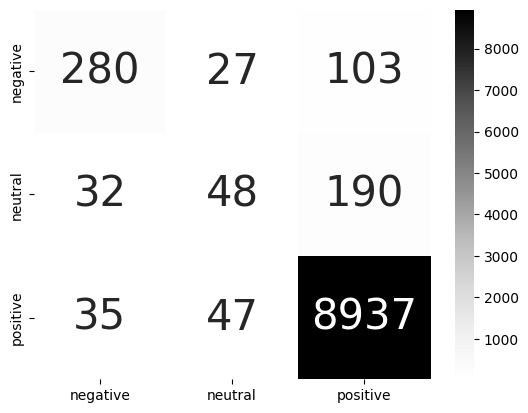

In [33]:
import matplotlib.pyplot as plt
import seaborn as sn
cf1 = confusion_matrix(all_true_labels, all_pred_labels)
df_cm1 = pd.DataFrame(cf1, index = ["negative","neutral","positive"],
                  columns = ["negative","neutral","positive"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})